# Исследование объявлений о продаже квартир

На основе данных от сервиса Яндекс.Недвижимость (архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет) необходимо установить параметры для разработки автоматизированной системы, которая определит рыночную стоимость объектов недвижимости, а также отследит аномалии и мошенническую деятельность. В датасете по каждой квартите содержатся как данные, вписанные пользователем, так и те, что получены автоматически на основе картографических данных (расстояние до центра, аэропорта и т.п.).

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd

flats = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

С заголовками таблицы всё в порядке, кроме cityCenters_nearest - его стоит заменить. Следует сменить представление с дробного на целочисленное там, где  это имеет смысл (например, количество парков в радиусе 3км). Также в таблице очень много пустых значений, некоторые из которых стоит заменить на среднее или медиану.

### Шаг 2. Предобработка данных

In [2]:
#переименовываем столбец 'cityCenters_nearest'
flats = flats.rename(columns={'cityCenters_nearest':'city_center_nearest'})

list_of_columns = ['last_price', 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']

#заменяем пустые значения в столбце "балкон" на 0 и переводим значения в целые числа
flats['balcony'] = flats['balcony'].fillna(0).astype('int')

#стоимость квартиры переводим в целое число
flats['last_price'] = flats['last_price'].astype('int')

#приводим значения столбца с датой и временем публикации в соответствующий формат
flats['first_day_exposition'] = pd.to_datetime(flats['first_day_exposition'], 
                                               format='%Y-%m-%dT%H:%M:%S')


present_date = pd.to_datetime('2019-05-02T00:00:00')
flats_datetime_values = flats.loc[:, ['first_day_exposition', 'days_exposition']]

#заполняем пустные значения столбца с апартаментами на False и меняем тип данных на булевый 
flats['is_apartment'] = flats['is_apartment'].fillna(False).astype('bool')

print(flats.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0         51.0      8         False  ...   
1             NaN          11.0         18.6      1         False  ...   
2             NaN           5.0         34.3      4         False  ...   
3             NaN          14.0          NaN      9         False  ...   
4            3.03          14.0         32.0     13         False  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0        0  Санкт-Петербург           18863.0   
1 

1. Пустые значения в столбцах с указанием населённого пункта (locality_name) заменить невозможно. Разработчикам следует отметить это поле как обязательное для заполнения.
2. Поле с указанием количества этажей в доме (floors_total) также невозможно заполнить, однако оно менее важно.
3. В столбце с датой публикации (first_day_exposition) всё время указано как "00:00:00". Следует либо отказаться от указания времени, так как в таком формате оно никаких полезных данных не даёт, либо проверить алгоритмы back-end.
4. Предположим, что владельцы апартаментов указывают тип своего жилья. Остальные не указывают, так как либо не знают, что такое апартаменты, либо считают отсутствие ответа отрицанием.


### Шаг 3. Посчитайте и добавьте в таблицу

In [3]:
#цена за квадратный метр
flats['meter_price'] = flats['last_price'] / flats['total_area']

#день недели, месяц и год публикации объявления
flats['weekday'] = flats['first_day_exposition'].dt.weekday
flats['month'] = flats['first_day_exposition'].dt.month
flats['year'] = flats['first_day_exposition'].dt.year

#этаж, на котором расположена квартира; варианты — первый, последний, другой
def categorize_floors(row):
    floor_number = row['floor']
    total_number = row['floors_total']
    
    if floor_number == total_number:
        return 'последний'
    elif floor_number == 1:
        return 'первый'
    else:
        return 'другой'

flats['floor_category'] = flats.apply(categorize_floors, axis=1)

#соотношение жилой и общей площади, а также отношение площади кухни к общей
flats['living_ratio'] = flats['living_area'] / flats['total_area']
flats['kitchen_ratio'] = flats['kitchen_area'] / flats['total_area']
print(flats.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70          16.0         51.0      8         False  ...   
1             NaN          11.0         18.6      1         False  ...   
2             NaN           5.0         34.3      4         False  ...   
3             NaN          14.0          NaN      9         False  ...   
4            3.03          14.0         32.0     13         False  ...   

   ponds_around3000  ponds_nearest  days_exposition    meter_price weekday  \
0               2.0          755.0              Na

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

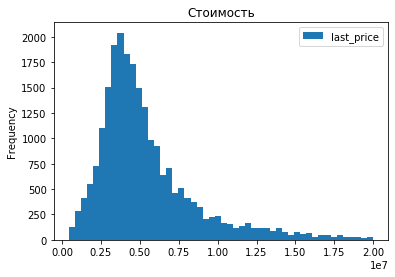

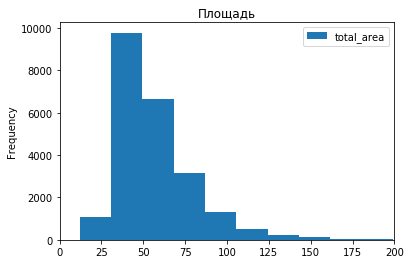

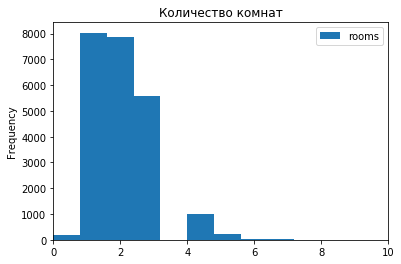

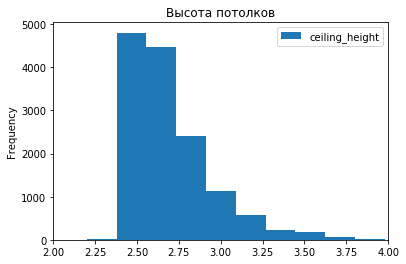

In [13]:
#Параметры: площадь, цена, число комнат, высота потолков

flats_price = flats.query('100000 < last_price < 20000000')
flats_price.plot(kind='hist', y='last_price', bins=50, title='Стоимость')

flats_area = flats_price.query('total_area < 200')
flats_area.plot(kind='hist', y='total_area', title='Площадь', xlim=(0, 200))

flats_rooms = flats_area.query('rooms < 10')
flats_rooms.plot(kind='hist', y='rooms', bins=10, title='Количество комнат', xlim=(0, 10))

flats_final = flats_rooms.query('2 < ceiling_height < 4')
flats_final.plot(kind='hist', y='ceiling_height', bins=10, title='Высота потолков', xlim=(2,4))

*Стоимость*
<br>При построении графиков стоимости квартир не учитывались значения выше 20 млн рублей, так как это выбивающиеся значения, их мало, но при этом они влияют на среднее, медиану и представление данных.
<br><br>
*Площадь*
<br>Для гистограммы с распределением площади также были исключены квартиры с площадью более 200 квадратных метров, так как даже стандартная 5-комнатная квартира, как правило, не выходит за эти рамки.
<br><br>
*Количество комнат*
<br>Отсекаем квартиры с более чем 10 комнатами. На графике видно, что наиболее популярными являются квартиры с 1-3 комнатами (пик наблюдается на 1-комнатных).
<br><br>
*Высота потолков*
<br>Высота потолков была ограничена диапазоном от 2 до 4 метров, так как данные о потолках меньше 2 метров кажутся недостоверными. Таким образом, наиболее популярными оказались потольки в диапазоне примерно 2,4 - 2,6 метров.

В среднем продажа квартиры занимает 181 день
Медианное время продаи квартиры: 95 дней


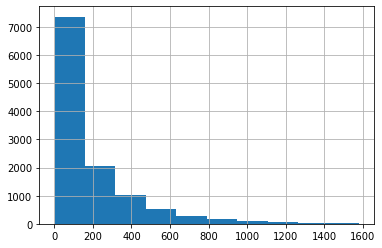

In [5]:
#гистограмма времени продажи квартиры
flats_final['days_exposition'].hist()

#среднее и медиана
print('В среднем продажа квартиры занимает {:.0f} день'.format(flats['days_exposition'].mean()))
print('Медианное время продаи квартиры: {:.0f} дней'.format(flats['days_exposition'].median()))

#новый массив без редких и выбивающихся значений
flats_new = flats_final.query('days_exposition < 730')

Из предоставленных данных можно сделать вывод о том, что в стандартном случае продажа квартиры может занимать от 1 дня до 3 месяцев. Менее, чем в трети случаев она занимает от 3 месяцев до года. Неоычно долгими можно считать продажу квартир от 2 лет и более.

In [6]:
#Какие факторы больше всего влияют на стоимость квартиры?
#зависимость цены от квадратного метра, числа комнат, этажа, удалённости от центра
print('Коэффициент корреляции Пирсона для:')
sq_m_corr = flats_new['last_price'].corr(flats_new['total_area'])
print('площади = {:.2f}'.format(sq_m_corr))

rooms_corr = flats_new['last_price'].corr(flats_new['rooms'])
print('количества комнат = {:.2f}'.format(rooms_corr))

center_corr = flats_new['last_price'].corr(flats_new['city_center_nearest'])
print('удалённости от центра = {:.2f}'.format(center_corr))

floor_corr = flats.pivot_table(index='floor_category', values='last_price', aggfunc='mean')
print()
print('Средняя цена в зависимости от этажа')
print(floor_corr)

Коэффициент корреляции Пирсона для:
площади = 0.78
количества комнат = 0.51
удалённости от центра = -0.35

Средняя цена в зависимости от этажа
                  last_price
floor_category              
другой          6.675444e+06
первый          4.820982e+06
последний       7.327011e+06


Больше всего на стоимость квартиры влияет её площадь (коэффициент = 0,77), причём зависимость прямая: чем больше площадь, тем выше цена, что вполне логично. Второй критерий - количество комнат. Его влияние на стоимость несколько ниже, чем площади, и зависимость остаётся прямой. Удалённость от центра - один из самых незначительных факторов, однако тоже оказывает некоторое влияние на стоимость в обратной пропорции (ближе к центру - дороже). Квартиры на первом этаже в среднем стоят дешевле, чем на этажах выше.

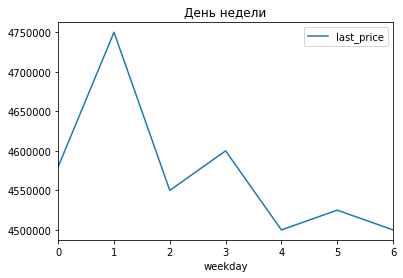

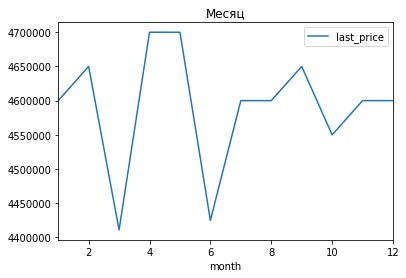

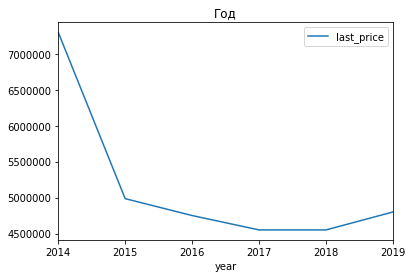

In [7]:
#зависимость от даты размещения: дня недели, месяца и года
price_by_day = (
    flats_new
    .pivot_table(index='weekday', values='last_price', aggfunc='median')
    .plot(title='День недели')
)
price_by_month = (
    flats_new
    .pivot_table(index='month', values='last_price', aggfunc='median')
    .plot(title='Месяц')
)
price_by_year = (
    flats_new
    .pivot_table(index='year', values='last_price', aggfunc='median')
    .plot(title='Год')
)

В марте и в июне наблюдаются самые низкие цены на жильё. Самые высокие - в апреле и мае. В 2014 году наблюдался пик роста цен на жильё, в 2015 они резко упали, достигнув минимума в 2017-2018 годах. Зависимость от дней недели кажется странным объектом анализа, однако оказалось, что самые высокие цены встречаются в объявлениях, опуликованных во вторник, а самые низкие - в пятницу и воскресенье. Полагаю, что это может зависеть от рабочего времени агенств недвижимости.

In [8]:
#10 населённых пунктов с наибольшим числом объявлений
top_10_areas = (
    flats_new
    .groupby('locality_name').count()
    .sort_values('last_price', ascending=False)
    .head(10)
    .index
)
print('10 населённых пунктов с наибольшим числом объявлений:')
for item in top_10_areas:
    print(item)
print()

#среднюю цену квадратного метра в этих населённых пунктах
top_areas_content = flats_new.loc[flats_new['locality_name'].isin(top_10_areas)]
mean_square = top_areas_content['meter_price'].mean()
print('Средняя цена квадратного метра: {:.0f} рублей'.format(mean_square))
print()

#населённые пункты с самой высокой и низкой стоимостью жилья
max_cost = top_areas_content['last_price'].max()
min_cost = top_areas_content['last_price'].min()

locality_max_cost = (
    top_areas_content
    .loc[top_areas_content['last_price'] == max_cost]
    ['locality_name']
)

locality_min_cost = (
    top_areas_content
    .loc[top_areas_content['last_price'] == min_cost]
    ['locality_name']
)

print('Населённый пункт с самой высокой стоимостью жилья -', locality_max_cost[975])
print('Населённый пункт с самой низкой стоимостью жилья -', locality_min_cost[13060])
#Эти данные можно найти по имени в столбце 'locality_name'. 

10 населённых пунктов с наибольшим числом объявлений:
Санкт-Петербург
Всеволожск
посёлок Мурино
посёлок Шушары
Колпино
Пушкин
Петергоф
посёлок Парголово
Гатчина
деревня Кудрово

Средняя цена квадратного метра: 103499 рублей

Населённый пункт с самой высокой стоимостью жилья - Санкт-Петербург
Населённый пункт с самой низкой стоимостью жилья - Гатчина


### Расчёты для центра Санкт-Петербурга

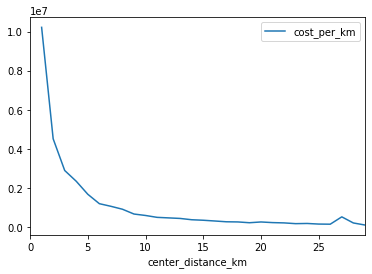

In [9]:
#квартиры в Санкт-Петербурге ('locality_name')
spb_flats = flats_new.query('locality_name == "Санкт-Петербург"')

pd.options.mode.chained_assignment = None

#столбец с расстоянием до центра в километрах, округлённый до целых значений
spb_flats['center_distance_km'] = spb_flats.loc[:,'city_center_nearest'] / 1000
spb_flats['center_distance_km'] = spb_flats['center_distance_km'].dropna().astype('int')

#средняя цена для каждого километра
spb_flats['cost_per_km'] = spb_flats['last_price'] / spb_flats['center_distance_km']

cost_distance_pivot = spb_flats.pivot_table(index='center_distance_km', values='cost_per_km', aggfunc='mean')

cost_distance_pivot.plot()

Центральной зоной Санкт-Петербурга можно считать территорию в радиусе 10 км от центра. 

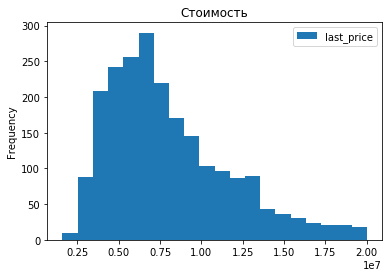

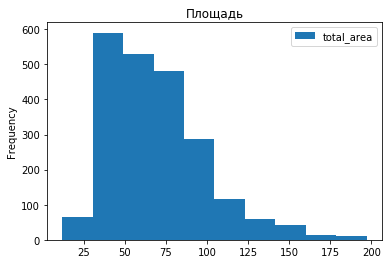

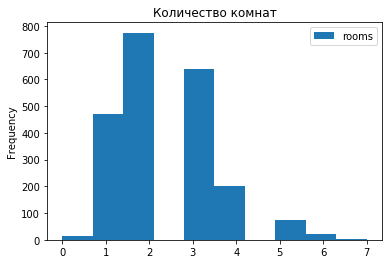

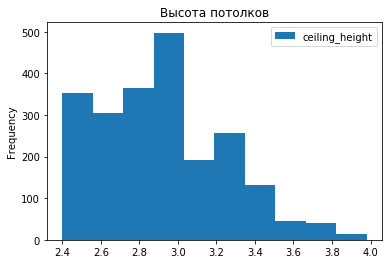

In [10]:
#Выделите сегмент квартир в центре.
spb_center_flats = spb_flats.query('center_distance_km < 10')
#Проанализируйте эту территорию и изучите следующие параметры:
#площадь, цена, число комнат, высота потолков.
spb_center_flats.plot(kind='hist', y='last_price', bins=20, title='Стоимость')
spb_center_flats.plot(kind='hist', y='total_area', title='Площадь')
spb_center_flats.plot(kind='hist', y='rooms', title='Количество комнат')
spb_center_flats.plot(kind='hist', y='ceiling_height', title='Высота потолков')
#Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж,
#удалённость от центра, дата размещения объявления).


*Стоимость*<br>
Распределение стоимости квартир в центре Санкт-Петербурга переместилась в сторону более высоких цен (вправо) по сравнению с распределением всех квартир. Таким образом, пик налюдается в районе 5-6 миллионов, а квартир за 2,5 миллионов в разы меньше.
<br><br>
*Площадь*<br>
Распределение площади в общих чертах похоже, но здесь не налюдается явных всплесков, как на общем графике.
<br><br>
*Количество комнат*<br>
В цкетре Санкт-Петербурга больше всего продаётся 2-комнатных квартир в отличие от общего результата по области, где самые популярные - 1-комнатные квартиры. Также в центре гораздо ольше 3-комнатных квартир.
<br><br>
*Высота потолков*<br>
В квартирах в центре Санкт-Петерурга нет потолков ниже 2,4 метра, а наиболее распространённой является высота 2,9-3 метра.


In [11]:
print('Коэффициент корреляции Пирсона для следующих факторов:')

center_sq_m = spb_center_flats['last_price'].corr(spb_center_flats['total_area'])
print('площади = {:.2f}'.format(center_sq_m))

center_rooms = spb_center_flats['last_price'].corr(spb_center_flats['rooms'])
print('количества комнат = {:.2f}'.format(center_rooms))

center_distance = spb_center_flats['last_price'].corr(spb_center_flats['city_center_nearest'])
print('удалённости от центра = {:.2f}'.format(center_distance))

center_floor = spb_center_flats.pivot_table(index='floor_category', values='last_price', aggfunc='mean')
print()
print('Средняя цена в зависимости от этажа')
print(center_floor)

Коэффициент корреляции Пирсона для следующих факторов:
площади = 0.77
количества комнат = 0.53
удалённости от центра = -0.31

Средняя цена в зависимости от этажа
                  last_price
floor_category              
другой          8.261792e+06
первый          6.297554e+06
последний       8.140933e+06


Коэффициент корреляции Пирсона одинаков для центра и для всего массива квартир. Однако цена на квартиры в центре зависит от категории этажа в меньшей степени. Так, например, разницы между последним и любым другим этажом практически нет. Тем не менее, квартиры на первом этаже по-прежнему стоят дешевле.

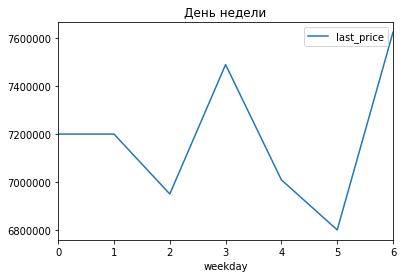

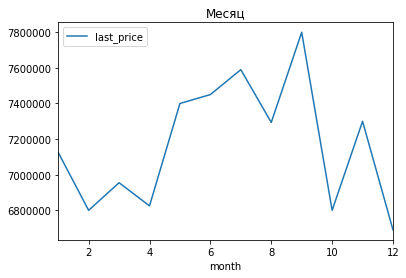

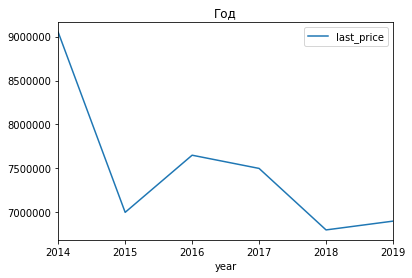

In [12]:
price_by_day = (
    spb_center_flats
    .pivot_table(index='weekday', values='last_price', aggfunc='median')
    .plot(title='День недели')
)
price_by_month = (
    spb_center_flats
    .pivot_table(index='month', values='last_price', aggfunc='median')
    .plot(title='Месяц')
)
price_by_year = (
    spb_center_flats
    .pivot_table(index='year', values='last_price', aggfunc='median')
    .plot(title='Год')
)

*День недели*<br>
Самыми активными днями публикации являются воскресенье и среда, что радикально отличается от общей картины. Популярность воскресенья можно объяснить тем, что владельцы квартир в центре предпочитают самостоятельно пуликовать объявления, а не пользоваться услугами агентств недвижимости.
<br><br>
*Месяц*<br>
Здесь график также отличается от общего. Общий график более-менее стабилен за исключением двух минимумов. В центре же наиболее популярный месяц размещения объявлений - сентябрь. Также большое количество публикуется в ноябре, но к декабрю количество объявлений резко падает.
<br><br>
*Год*<br>
Падение цен после 2014 года сказалось и на владельцах квартир в центре Санкт-Петербурга. Однако в отличие от общей картины в 2016-2017 этот сегмент рынка пережил временный рост. Затем цены снизились и почти не изменились в 2019 году.

### Шаг 5. Общий вывод

На основании расчёта коэффициента корреляции Пирсона и построения сводных таблиц и графиков для создания системы оценки стоимости недвижимости, а также с целью выявления мошенничества следует принять во внимание следующие параметры:
- площадь
- количество комнат
- удалённость от центра
- этаж (первый или другой)